In [1]:
# https://www.datacamp.com/tutorial/fuzzy-string-python
# https://towardsdatascience.com/fuzzy-string-matching-in-python-68f240d910fe#:~:text=Fuzzywuzzy%20is%20a%20python%20library,showcase%20them%20on%20one%20platform.


In [1]:
# !pip install wandb
# !pip install transformers
# !pip install sentencepiece

from transformers import T5TokenizerFast, T5ForConditionalGeneration 
from transformers import Trainer

import os
import time 

# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3" 
import pandas as pd
import numpy as np
import torch
import torchvision
import Levenshtein
from fuzzywuzzy import fuzz
from datasets import list_metrics
from sklearn.metrics import precision_recall_fscore_support

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# wandb.login()

# os.environ["WANDB_DISABLED"] = "true"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Create torch dataset
# https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels['input_ids'][idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [3]:
# conellpp_test.to_csv('./1-NER_Data/1-csv_format/test/conell_test_data.csv', index = False)
# wikineural_test.to_csv('./1-NER_Data/1-csv_format/test/wiki_neural_test_data.csv', index = False)
# onto_test.to_csv('./1-NER_Data/1-csv_format/test/onto_test_data.csv', index = False)
# wnut_test.to_csv('./1-NER_Data/1-csv_format/test/wnut_test_data.csv', index = False)

In [4]:
def read_test_data(path):
    return pd.read_csv(path)

In [5]:
def encode_input_as_tokens(dataset):
    tokens = []
    for text in dataset["input_text"]:
        tokens.append(tokenizer('ner: ' + text, return_tensors="pt", padding=True, truncation=True, max_length=512).input_ids)
    return tokens

In [6]:
def predict_ner(model, tokens):
    results = []
    model = model.to(device)
    counter =0
    for token in tokens:
        results.append(model.generate(token.to(device))) 
        counter +=1
        if counter % 100==0:
            print(counter)
    return results

In [7]:
def decode_prediction(predicted_tokens):
    final_ouput_2 = []
    for result in predicted_tokens:
        final_ouput_2.append(tokenizer.decode(result[0], skip_special_tokens=True))
    return final_ouput_2

In [8]:
def compare_prediction_with_target(predictions, target_text):
    counter = 0
    for i in range(len(predictions)):
        if predictions[i] != target_text[i]:
            counter += 1
    return 1- counter/len(predictions)

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [10]:
max_source_length = 512
max_target_length = 512

In [24]:
tokenizer = T5TokenizerFast.from_pretrained("t5-base")
model_path = "./NER_full_sent_add_space_before_bracket_diff_seperators_v2/checkpoint-35700"
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)

In [25]:
# from transformers import Seq2SeqTrainingArguments

# test_args = Seq2SeqTrainingArguments(
#     "test_trainer",
#     per_device_train_batch_size = 8,
#     per_device_eval_batch_size = 8,
#     eval_accumulation_steps = 50,  # VIP
#     predict_with_generate=True
# )

In [26]:
# from transformers import Seq2SeqTrainer

# trainer = Seq2SeqTrainer(
#     model=model, 
#     args=test_args
# #     train_dataset= train_dataset, 
# #     eval_dataset= eval_dataset
# )

## conell test data 

In [27]:
conell_test_data = read_test_data('./1-NER_Data/1-csv_format/test/conell_test_data_full_sentence.csv')
conell_test_data

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...","SOCCER - <s> JAPAN <e> GET LUCKY WIN , <s> CHI...",9,2,0.2
1,Nadim Ladki,<s> Nadim Ladki <e>,2,2,1.0
2,"AL-AIN , United Arab Emirates 1996-12-06","<s> AL-AIN <e> , <s> United Arab Emirates <e> ...",5,4,0.8
3,Japan began the defence of their Asian Cup tit...,<s> Japan <e> began the defence of their <s> A...,24,4,0.2
4,But China saw their luck desert them in the se...,But <s> China <e> saw their luck desert them i...,23,2,0.1
...,...,...,...,...,...
3444,It all culminated in the fact that I now have ...,It all culminated in the fact that I now have ...,17,1,0.1
3445,That is why this is so emotional a night for m...,That is why this is so emotional a night for m...,13,1,0.1
3446,""" It was the joy that we all had over the peri...",""" It was the joy that we all had over the peri...",27,0,0.0
3447,"Charlton managed Ireland for 93 matches , duri...",<s> Charlton <e> managed <s> Ireland <e> for 9...,24,2,0.1


<AxesSubplot:>

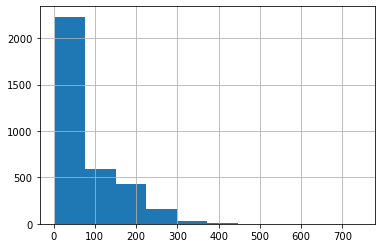

In [28]:
conell_test_data['target_text'].str.len().hist()

In [29]:
conell_tokens = encode_input_as_tokens(conell_test_data)

In [30]:
len(conell_tokens)

3449

In [31]:
start = time.time()
counter = 0
conell_pred = []
for token in conell_tokens:
    if counter%200 == 0:
        print(counter)
    counter += 1
    prediction = model.generate(token.to(device))
    conell_pred.append(prediction)
    
print(time.time() - start)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
849.4696176052094


In [32]:
# conell_pred = predict_ner(model, conell_tokens)

In [33]:
conell_pred_decoded = decode_prediction(conell_pred)

In [34]:
conell_target_text = conell_test_data['target_text']

In [35]:
conell_pred_decoded

['SOCCER - s> JAPAN e> GET ',
 's> Nadim Ladki e>',
 's> AL-AIN e>, s> United Arab',
 's> Japan e> began the defence of their s> Asian',
 'But s> China e> saw their luck desert them in the second match',
 's> China e> controlled most of the match and saw several chances missed',
 's> Oleg Shatskiku e> made sure of the win',
 'The former s> Soviet e> republic was playing in an s',
 'Despite winning the s> Asian Games e> title two years ago ',
 'Two goals from defensive errors in the last six minutes allowed s> Japan e',
 's> Takuya Takagi e> scored the winner in the',
 'It was the second costly blunder by s> Syria e>',
 'Defender s> Hassan Abbas e> rose to intercept a',
 's> Nader Jokhadar e> had given s>',
 's> Japan e> then laid siege to the s>',
 's> Bitar e> pulled off fine saves whenever they did ',
 's> Japan e> coach s> Shu Kamo ',
 'The s> Syrians e> scored early and then played defensively and',
 's> Japan e>, co-hosts of the ',
 'Hosts s> UAE e> play s> Kuwait',
 'All four tea

In [39]:
conell_target_text.iloc[3]

'<s> Japan <e> began the defence of their <s> Asian Cup <e> title with a lucky 2-1 win against <s> Syria <e> in a Group C championship match on Friday .'

In [36]:
conell_target_text.head(50)

0     SOCCER - <s> JAPAN <e> GET LUCKY WIN , <s> CHI...
1                                   <s> Nadim Ladki <e>
2     <s> AL-AIN <e> , <s> United Arab Emirates <e> ...
3     <s> Japan <e> began the defence of their <s> A...
4     But <s> China <e> saw their luck desert them i...
5     <s> China <e> controlled most of the match and...
6     <s> Oleg Shatskiku <e> made sure of the win in...
7     The former <s> Soviet <e> republic was playing...
8     Despite winning the <s> Asian Games <e> title ...
9     Two goals from defensive errors in the last si...
10    <s> Takuya Takagi <e> scored the winner in the...
11    It was the second costly blunder by <s> Syria ...
12    Defender <s> Hassan Abbas <e> rose to intercep...
13    <s> Nader Jokhadar <e> had given <s> Syria <e>...
14    <s> Japan <e> then laid siege to the <s> Syria...
15    <s> Bitar <e> pulled off fine saves whenever t...
16    <s> Japan <e> coach <s> Shu Kamo <e> said : ' ...
17    The <s> Syrians <e> scored early and then 

In [22]:
conell_accuracy = compare_prediction_with_target(conell_pred_decoded, conell_target_text)
conell_accuracy

0.06320672658741666

In [23]:
conell_accuracy = compare_prediction_with_target(conell_pred_decoded, conell_target_text)
conell_accuracy

0.06320672658741666

In [24]:
# lower_normal
conell_accuracy = compare_prediction_with_target(conell_pred_decoded, conell_target_text)
conell_accuracy

0.06320672658741666

In [25]:
# predictions = pd.DataFrame({'predictions':conell_pred_decoded, 'actual':conell_target_text}) 

In [26]:
# predictions.to_csv('./1-NER_Data/2-predictions/lower_normal_conell.csv')

In [27]:
conell_false_pos = 0
conell_false_neg = 0
conell_true_pos = 0
conell_errors = 0

for i in range(len(conell_pred_decoded)):
    split_predicted_entities = conell_pred_decoded[i].split(',')
    split_target_entities = conell_target_text[i].split(',')
    
    for pred in split_predicted_entities:
        if pred in split_target_entities:
            conell_true_pos += 1
        else:
            print(split_predicted_entities) 
            print(split_target_entities)
            conell_errors += 1
        if len(split_predicted_entities) > len(split_target_entities):
            conell_false_pos += len(split_predicted_entities) - len(split_target_entities)
        elif len(split_predicted_entities) < len(split_target_entities):
            conell_false_neg += len(split_target_entities) - len(split_predicted_entities)

['SOCCER -  JAPAN > GET LUCKY WIN']
['SOCCER - < JAPAN > GET LUCKY WIN ', ' < CHINA > IN SURPRISE DEFEAT .']
[' Nadim Ladki >']
['< Nadim Ladki >']
[' AL-AIN >', '  United Arab Emirates > 1996-12-06']
['< AL-AIN > ', ' < United Arab Emirates > 1996-12-06']
[' AL-AIN >', '  United Arab Emirates > 1996-12-06']
['< AL-AIN > ', ' < United Arab Emirates > 1996-12-06']
[' Japan > began the defence of their  Asian Cup > title with a lucky']
['< Japan > began the defence of their < Asian Cup > title with a lucky 2-1 win against < Syria > in a Group C championship match on Friday .']
['But  China > saw their luck desert them in the second match of the group', '']
['But < China > saw their luck desert them in the second match of the group ', ' crashing to a surprise 2-0 defeat to newcomers < Uzbekistan > .']
['But  China > saw their luck desert them in the second match of the group', '']
['But < China > saw their luck desert them in the second match of the group ', ' crashing to a surprise 2-0 d

['The city in late June sold its first issue of < Euronotes > ', ' a strategy that it says saved it $ 500', '000 in interest costs ', ' and it has been trying to build on this strategy of expanding the pool of potential investors since then .']
['The city in late June sold its first issue of  Euronotes >', ' ']
['The city in late June sold its first issue of < Euronotes > ', ' a strategy that it says saved it $ 500', '000 in interest costs ', ' and it has been trying to build on this strategy of expanding the pool of potential investors since then .']
['In November', '  New York City > said it became the first  U.']
['In November ', ' < New York City > said it became the first < U.S. > municipality to offer bonds for sale in < European > markets by competitive bidding as it listed taxable bonds on the < London Stock Exchange > .']
['In November', '  New York City > said it became the first  U.']
['In November ', ' < New York City > said it became the first < U.S. > municipality to offe

['< Italy > evacuates 17 nuns and priests from < Zaire > .']
[' ROME > 1996-12-06']
['< ROME > 1996-12-06']
[' Italy > said on Friday it had evacuated 17  Roman Catholic > nuns']
['< Italy > said on Friday it had evacuated 17 < Roman Catholic > nuns and priests from < Zaire > where they had been at risk from fighting between government troops and ethnic < Tutsi > rebels .']
['The  Foreign Ministry > said the 10 Europeans and seven Africans took a special']
['The < Foreign Ministry > said the 10 < Europeans > and seven < Africans > took a special flight from the < Garamba > national park in northern < Zaire > to the < Ugandan > capital < Kampala > where they were being looked after at the < Italian > embassy .']
['The group had travelled from their mission on the edge of the park to a landing strip']
['The group had travelled from their mission on the edge of the park to a landing strip to make the rendezvous ', ' a ministry official said .']
['The ministry said the group consisted of 1

['< Indonesian > keeper < Hendro Kartiko > produced a string of fine saves to prevent the < Koreans > increasing their lead .']
[' Indonesia > : 20 -  Hendro Kartiko > ;']
['< Indonesia > : 20 - < Hendro Kartiko > ; 2 - < Agung Setyabudi > ; 3 - < Suwandi Siswoyo > ; 4 - < Yeyen Tumera > ; 5 - < Aples Tecuari > ; 6 - < Sudiriman > ; 7 - < Widodo Gahyo Purta > ; 8 - < Ronny Wabia > ; 11 - < Bima Sakti > ; 12 - < Chris Yarangga > ( 15 - < Francis Wewengken > 36 ) ; 16 - < Marzuki Badriawan > .']
[' South Korea > : 1 -  Kim Byung Ji > ;']
['< South Korea > : 1 - < Kim Byung Ji > ; 2 - < Kim Pan Keun > ; 5 - < Huh Ki Tae > ; 8 - < Roh Sang Rae > ( 7 - < Sin Tae Yong > 33 ) ; 9 - < Kim Do Hoon > ; 11 - < Ko Jeong Woon > ; 17 - < Ha Seok Ju > ; 18 - < Hwang Sun Hong > ; 22 - < Lee Young Jin > ; 23 - < Yoo Sang Chul > ; 24 - < Kim Joo Sung > .']
['SOCCER -  ISRAELI > FIRST DIVISION RESULTS']
['SOCCER - < ISRAELI > FIRST DIVISION RESULTS / STANDINGS .']
[' JERUSALEM > 1996-12-07']
['< JERUSALE

In [28]:
conell_errors

3943

In [29]:
conell_true_pos/(conell_true_pos+conell_errors)

0.09293765815504947

In [30]:
# Precision = TP/TP+FP
conell_true_pos/(conell_true_pos+conell_false_pos+conell_errors)

0.09293765815504947

In [31]:
# Recall = TP/TP+FN
conell_true_pos/(conell_true_pos+conell_false_neg+conell_errors)

0.06913073237508556

In [32]:
# conell_false_pos
# conell_false_neg
conell_errors

3943

In [33]:
conell_true_pos/(conell_true_pos+conell_errors)

0.09293765815504947

In [34]:
# Precision = TP/TP+FP
conell_true_pos/(conell_true_pos+conell_false_pos+conell_errors)

0.09293765815504947

In [35]:
# Recall = TP/TP+FN
conell_true_pos/(conell_true_pos+conell_false_neg+conell_errors)

0.06913073237508556

In [36]:
# lower_normal = 0.88
conell_true_pos/(conell_true_pos+conell_errors)

0.09293765815504947

In [37]:
# lower_normal
# Precision = TP/TP+FP = 0.859
conell_true_pos/(conell_true_pos+conell_false_pos+conell_errors)

0.09293765815504947

In [25]:
conell_true_pos/(conell_true_pos+conell_errors)

0.8797457178174113

In [26]:
# Precision = TP/TP+FP
conell_true_pos/(conell_true_pos+conell_false_pos+conell_errors)

0.8610438990667127

In [27]:
# Recall = TP/TP+FN
conell_true_pos/(conell_true_pos+conell_false_neg+conell_errors)

0.631752472736495

In [114]:
# lower_normal = 0.88
conell_true_pos/(conell_true_pos+conell_errors)

0.8816766890696852

In [118]:
# lower_normal
# Precision = TP/TP+FP = 0.859
conell_true_pos/(conell_true_pos+conell_false_pos+conell_errors)

0.8597792342186961

In [117]:
# lower_normal
# Recall = TP/TP+FN = 0.63
conell_true_pos/(conell_true_pos+conell_false_neg+conell_errors)

0.633418043202033

In [57]:
f1_score(conell_target_text, conell_pred_decoded, average='macro')

0.5511930634811548

In [58]:
f1_score(conell_target_text, conell_pred_decoded, average='micro')

0.795592925485648

In [59]:
f1_score(conell_target_text, conell_pred_decoded, average='weighted')

0.7995816577656156

['*JAPAN*', '*CHINA*']

In [62]:
target_encodings = []
for text in conell_test_data["target_text"]:
    target_encodings.append(tokenizer('ner: ' + text, return_tensors="pt", padding=True, truncation=True, max_length=512).input_ids)

In [65]:
len(conell_tokens)

3449

In [73]:
len(target_encodings[0][0])

14

In [74]:
f1_score(target_encodings[0][0], conell_tokens[0][0])

ValueError: Found input variables with inconsistent numbers of samples: [14, 34]

In [67]:
score = 0
for i in range(len(conell_tokens)):
    score += f1_score(target_encodings[i], conell_tokens[i])
score/len(conell_tokens)

ValueError: multiclass-multioutput is not supported

## wikineural test data

In [22]:
wiki_test_data = read_test_data('./1-NER_Data/1-csv_format/test/wiki_neural_test_data_full_sentence.csv')
wiki_test_data

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,On this occasion he failed to gain the support...,*South Wales Miners ' Federation*,20,4,0.2
1,On both these occasions he was backed by the S...,*South Wales Miners ' Federation*,18,4,0.2
2,"He also appeared as himself in the 1996 film ""...",*Eddie*,10,1,0.1
3,The Colorado Rockies were created as an expans...,"*Colorado Rockies*,*Coors Field*",17,4,0.2
4,He kept busy recording demo tapes at his home ...,"*La Valencia Hotel*,*La Jolla*",29,5,0.2
...,...,...,...,...,...
11592,"com , Amazon .",*Amazon*,2,1,0.5
11593,"In January 2013 , the European Food Safety Aut...","*European Food Safety Authority*,*Monsanto*",27,5,0.2
11594,"All of the games had art true to the series , ...",*Sega*,23,1,0.0
11595,There was also a game made for the Game Boy ba...,*Game Boy*,20,2,0.1


In [23]:
wiki_tokens = encode_input_as_tokens(wiki_test_data)

In [24]:
len(wiki_tokens)

11597

In [25]:
wiki_pred = predict_ner(model, wiki_tokens)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500


In [26]:
wiki_pred_decoded = decode_prediction(wiki_pred)

In [27]:
wiki_target_text = wiki_test_data['target_text']

In [28]:
wiki_accuracy = compare_prediction_with_target(wiki_pred_decoded, wiki_target_text)
wiki_accuracy

0.7992584289040269

In [ ]:
evaluations(predictions=conell_pred_decoded, references=conell_target_text):

## onto test data

In [29]:
onto_test_data = read_test_data('./1-NER_Data/1-csv_format/test/onto_test_data_full_sentence.csv')
onto_test_data

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,`` We 're being bombarded by new Treasury and ...,"*Treasury*,*Dean Witter Reynolds Inc*,*William...",26,2,0.1
1,"[buabua] Over these years, our country has bee...",**,30,0,0.0
2,Sometimes they mixed the ink with glue to prod...,**,12,0,0.0
3,"In over-the-counter trading Friday, Weisfield'...","*Friday*,*9.50*,*39*,*Weisfield's*",11,3,0.3
4,"Prince William is chasing a polo ball, such of...","*British*,*Prince William*",18,2,0.1
...,...,...,...,...,...
11471,"Earlier this year, bankers and other investors...","*Earlier this year*,*Rosenthal*",28,2,0.1
11472,"When he retired last year, he was the oldest a...",*last year*,16,1,0.1
11473,"At the same time, Westinghouse hopes its ventu...","*U.S.*,*European*,*Westinghouse*,*Mitsubishi*,...",36,3,0.1
11474,yeah,**,1,0,0.0


In [30]:
onto_tokens = encode_input_as_tokens(onto_test_data)

In [31]:
len(onto_tokens)

11476

In [32]:
onto_pred = predict_ner(model, onto_tokens)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400


In [33]:
onto_pred_decoded = decode_prediction(onto_pred)

In [34]:
onto_target_text = onto_test_data['target_text']

In [35]:
onto_accuracy = compare_prediction_with_target(onto_pred_decoded, onto_target_text)
onto_accuracy

0.7328337399790867

In [ ]:
evaluations(predictions=conell_pred_decoded, references=conell_target_text):

## wnut test data 

In [36]:
wnut_test_data = read_test_data('./1-NER_Data/1-csv_format/test/wnut_test_data.csv')
wnut_test_data

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,& gt ; * The soldier was killed when another a...,*Sonmarg*,27,1,0.0
1,& gt ; * Police last week evacuated 80 village...,*Waltengoo Nar*,34,2,0.1
2,The bodies of the soldiers were recovered afte...,"*Avalanche Rescue Teams*,*ART*",32,4,0.1
3,& gt ; * Arrangements are in place to carry th...,*Colonel Rajesh Kalia*,33,3,0.1
4,Visuals of the avalanche site in Gurez sector .,*Gurez sector*,9,2,0.2
...,...,...,...,...,...
810,RT @ marIboros : short girls were born with at...,*marIboros*,11,1,0.1
811,A proper # StPatricksDay drink https://t.co/c4...,**,6,0,0.0
812,Never Been To Shakers Before,*Shakers*,5,1,0.2
813,No Cousins today . . . Pelicans offence could ...,"*Cousins*,*Pelicans*,*Holiday*",22,3,0.1


In [37]:
wnut_tokens = encode_input_as_tokens(wnut_test_data)

In [38]:
len(wnut_tokens)

815

In [39]:
wnut_pred = predict_ner(model, wnut_tokens)

100
200
300
400
500
600
700
800


In [40]:
wnut_pred_decoded = decode_prediction(wnut_pred)

In [41]:
wnut_target_text = wnut_test_data['target_text']

In [42]:
wnut_accuracy = compare_prediction_with_target(wnut_pred_decoded, wnut_target_text)
wnut_accuracy

0.49693251533742333

In [ ]:
evaluations(predictions=wnut_pred_decoded, references=wnut_target_text):